### APS 1052 Final Project

The focus of the team's model is going to be the seed model from the book Machine Learning and Data Science Blueprints for Finance. The model is going to be using stock data provided via the Google Drive, sub-folder > IntraDayData > TradeAndQuoteETFData. The goal of our model is to use the stock regression model provided from the book to predict the future price of an ETF. 


For this case study, the independent variables used are the following potentially correlated assets:

Stocks: Apple, Meta, Microsoft, Tesla

ETFs: QQQ, SPY

Indices: S&P500, Dow Jones, VIX

In [1122]:
# Load libraries
import numpy as np
import pandas as pd

## Note -  Nov 25 meeting:
Features: SMA, RSI,ROC,MOM,lags

Technical Indicators: Talib (metioned above) VIX, historical(https://www.cboe.com/tradable_products/vix/vix_historical_data/), Alternative Money Flow, Put-Call Parity

Input processing: smoothing(exp)

Metrics: same as homework



In [1123]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor



#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [1124]:
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import spearmanr

from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import fAux
import detrendPrice

In [1125]:
# stocks
appl_data = pd.read_csv('AAPL.csv')
jpm_data = pd.read_csv('JPM.csv')
msft_data = pd.read_csv('MSFT.csv') 
amzn_data = pd.read_csv('AMZN.csv')

# ETFs
spy_data = pd.read_csv('SPY.csv')
qqq_data = pd.read_csv('QQQ.csv')
ief_data = pd.read_csv('IEF.csv')
# indices 
vix_data = pd.read_csv('^VIX.csv')
dia_data = pd.read_csv('DIA.csv')
sp500_data = pd.read_csv('SP500.csv')

# predicting stock (y-variable)
ivv_data = pd.read_csv('IVV.csv')

In [1126]:
# function to clean the data 
# changes dates to datetime format & ensures all numbers are type float64 
def clean_data(df): 
    cleaned_df = pd.DataFrame()
    cleaned_df["Date"] = pd.to_datetime(df.iloc[:, 0])
    cleaned_df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(str).astype(float)
    return cleaned_df
 
    
df_list = [appl_data, jpm_data, msft_data, amzn_data, spy_data, qqq_data,
        vix_data, dia_data, sp500_data, ivv_data]

# iterates through list of all dataframes and cleans format 
for stock in df_list: 
    df = pd.DataFrame()
    df = clean_data(stock)
    stock = df

In [1127]:
stk_tickers = ['AAPL', 'JPM', 'MSFT','AMZN']
etf_tickers = ['SPY', 'QQQ']
idx_tickers = ['SP500', 'DIA','^VIX']

In [1128]:
import talib as ta
def get_indicator(df,indicator):
    ret_df = df
    timeperiod = 5
    if 'MACD' in indicator: #Moving Average Convergence Divergence
        macd, macdsignal, macdhist = ta.MACD(df.Close.values, fastperiod=12, slowperiod=26, signalperiod=9)
        ret_df = ret_df.join(pd.DataFrame([macd, macdsignal, macdhist]).T.rename(columns={0: "Macddif", 1: "Macddem", 2: "Macdhist"}))
    if 'MFI' in indicator: 
        mfi = ta.MFI(np.reshape(df.High.values.astype('float64'),-1), \
            np.reshape(df.Low.values.astype('float64'),-1), np.reshape(df.Close.values.astype('float64'),-1),\
                 np.reshape(df.Volume.values.astype('float64'),-1), timeperiod=timeperiod)
        ret_df = ret_df.join(pd.DataFrame([mfi]).T.rename(columns={0: "Mfi"}))
    if 'SMA' in indicator: 
        sma = ta.SMA(df.Close.values)
        ret_df = ret_df.join(pd.DataFrame([sma]).T.rename(columns={0: "Sma"}))
    if 'MOM' in indicator: 
        mom = ta.MOM(df.Close.values, timeperiod=timeperiod)
        ret_df = ret_df.join(pd.DataFrame([mom]).T.rename(columns={0: "Mom"}))  
    if 'ROC' in indicator: 
        roc = ta.ROC(df.Close.values, timeperiod=timeperiod)
        ret_df = ret_df.join(pd.DataFrame([roc]).T.rename(columns={0: "Roc"}))  
    if 'RSI' in indicator: 
        rsi = ta.RSI(df.Close.values, timeperiod=timeperiod)
        ret_df = ret_df.join(pd.DataFrame([rsi]).T.rename(columns={0: "Rsi"}))  
    if 'ATR' in indicator: #Volatility Indicator   -   Average True Range
        rsi = ta.ATR(df.High.values,df.Low.values,df.Close.values, timeperiod=timeperiod)
        ret_df = ret_df.join(pd.DataFrame([rsi]).T.rename(columns={0: "Atr"}))  
    return ret_df

In [1129]:
#### TECHNICAL INDICATOR ########################################################################################################### 
#### LAGS 

# create function to calculate lags based on return period (value can be changed)
return_period = 5

def calc_general_lag(df):
    temp = pd.DataFrame(np.log(df["Adj Close"]).diff(return_period).shift(-return_period))
    return temp

# iterate through entire list except for ivv_data 
appended_data = []
for stock in df_list:
    temp = calc_general_lag(stock)
    appended_data.append(temp)


dataset = pd.DataFrame()
dataset = pd.concat(appended_data, axis=1)
col_names = ["AAPL", "JPM", "MSFT", "AMZN", "SPY", "QQQ", "VIX", "DIA", "SP500", "IVV_pred"]
dataset.columns = col_names


# calculate lags specifically for the y-variable (IVV) - lags are in multiples of 3 
ivv_lags = pd.concat([np.log(ivv_data["Adj Close"]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*10]], axis=1)
ivv_lags.columns = ["IVV_" + str(return_period), "IVV_" + str(return_period*3), "IVV_" + str(return_period*6), "IVV_" + str(return_period*10)]

# full dataset with all X and Y variables 
full_data = pd.concat([dataset, ivv_lags], axis=1).dropna().iloc[::return_period, :]

# data description 
data_descrip = full_data.describe()


# set the X and Y variables 
CopyX = full_data[["IVV_pred"]].copy()
Y = full_data[["IVV_pred"]].reset_index(drop= True)
X = full_data.loc[:, full_data.columns != 'IVV_pred'].reset_index(drop= True)

In [1130]:
# calculate mfi using yahoo data
p1=pd.DataFrame(np.log(spy_data['Adj Close']))
p2=pd.DataFrame(np.log(ief_data['Adj Close']))
mfi=(p1.subtract(p2).dropna())
mfi=mfi.rolling(20).mean()
mfi.columns = ['Mfi']
X = X.join(mfi)

In [1131]:
ivv = get_indicator(ivv_data, ['SMA','RSI','ROC','MOM','ATR'])
X = X.join(ivv.iloc[:,-5:])
X = X.fillna(X.mean())

In [1132]:
from sklearn.preprocessing import StandardScaler
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=1)

scaler = StandardScaler()
scaler.fit(y_train)
# transform training dataset
y_train = pd.DataFrame(scaler.transform(y_train))
# transform test dataset
y_test = pd.DataFrame(scaler.transform(y_test))

# fit scaler on training dataset
scaler.fit(x_train)
# transform training dataset
x_train = pd.DataFrame(scaler.transform(x_train))
# transform test dataset
x_test = pd.DataFrame(scaler.transform(x_test))

In [1133]:
X_tosmooth = x_train.drop(x_train.iloc[:,-5:],axis=1)

x_train_smooth = X_tosmooth.join(x_train.iloc[:,-5:])
x_train_smooth

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.012965,-1.366871,-0.524865,-0.823582,-0.418799,-0.599277,0.113306,-0.404057,-0.478407,-1.025749,-0.776281,-1.359067,-0.613788,0.585987,0.227065,-0.769745,-0.682614,-1.051121,-0.546295
1,1.336751,0.215212,0.611612,-0.070411,1.010492,1.618100,-0.436476,0.668969,0.976309,-0.391669,-0.198794,0.130591,0.624353,-2.222788,-1.993178,0.194855,0.242646,0.251825,2.132624
2,-1.435036,0.237346,-0.837076,-1.077563,-0.363540,-0.646297,0.137205,-0.168138,-0.423821,1.053081,0.076125,0.539697,1.029127,-1.586162,-1.860320,1.621010,1.834883,1.004705,2.163594
3,0.857064,0.282621,1.009623,0.332737,0.390724,0.292440,-0.968806,0.164007,0.331103,0.227520,-0.612702,-0.667217,-0.454063,-1.387128,-1.565993,-0.909766,-1.006648,-1.020278,1.280941
4,-0.699959,0.074067,-0.331308,0.243286,-0.093774,-0.273744,0.029358,-0.003473,-0.085361,-0.365024,0.029474,-0.173335,0.388039,-1.590073,-1.547910,0.526764,0.643374,-0.131582,1.530497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,0.126061,0.770662,0.372875,1.146512,0.621788,0.496284,0.643185,0.812529,0.608867,0.753491,0.529532,0.756449,0.666833,0.907408,0.975445,-0.707507,-0.590997,-0.977802,-0.518961
477,0.886978,-0.304177,0.260029,-0.488678,-0.685745,-0.068778,-0.305941,-0.475703,-0.526919,0.630482,-0.486816,-0.228020,-0.258947,-1.388223,-1.784529,-1.713596,-1.837632,-0.789030,1.964686
478,-1.383595,-1.235280,-2.000596,-1.071085,-2.451598,-2.058591,2.251556,-2.877571,-2.448517,-0.249391,0.648970,0.450905,0.114355,1.415893,1.372303,-0.277067,-0.239723,-0.026851,-0.307860
479,0.814227,-0.244502,-0.375684,-0.645530,-0.121611,0.246045,0.241897,-0.099898,-0.059565,0.927802,-0.066701,0.139244,0.560489,-0.954844,-0.865972,0.905341,0.914102,0.373661,0.412306


In [1134]:
X.corr()
#pyplot.figure(figsize=(15,15))
#scatter_matrix(X.corr(),figsize=(12,12))
#pyplot.show()

,AAPL,JPM,MSFT,AMZN,SPY,QQQ,VIX,DIA,SP500,IVV_5,IVV_15,IVV_30,IVV_50,Mfi,Sma,Mom,Roc,Rsi,Atr
AAPL,1.000000,0.305085,0.374182,0.341090,0.508376,0.630327,-0.375315,0.462715,0.514504,0.052898,-0.001060,0.022198,0.008912,-0.034268,-0.035807,0.019848,0.016499,0.024655,0.001046
JPM,0.305085,1.000000,0.404957,0.321688,0.700155,0.572727,-0.434409,0.677653,0.711051,-0.022139,-0.091930,-0.014250,-0.045694,-0.002594,0.006097,0.010438,0.004434,0.026178,0.017965
MSFT,0.374182,0.404957,1.000000,0.430738,0.661247,0.705917,-0.481637,0.636991,0.662547,-0.049257,-0.024496,-0.022113,-0.031478,0.057585,0.062477,-0.012184,-0.024412,0.024072,-0.051664
AMZN,0.341090,0.321688,0.430738,1.000000,0.512033,0.633835,-0.380498,0.460440,0.514836,-0.014158,-0.019101,-0.034357,-0.043990,0.017130,0.029416,-0.037065,-0.035933,-0.023778,-0.009977
SPY,0.508376,0.700155,0.661247,0.512033,1.000000,0.901621,-0.694922,0.969449,0.997124,0.002655,-0.063858,-0.050724,-0.068189,0.015684,0.024768,0.010735,0.004155,0.028912,-0.003337
QQQ,0.630327,0.572727,0.705917,0.633835,0.901621,1.000000,-0.676902,0.840862,0.904153,-0.007230,-0.055467,-0.044534,-0.063117,0.032352,0.040797,-0.004440,-0.011171,0.012880,-0.015957
VIX,-0.375315,-0.434409,-0.481637,-0.380498,-0.694922,-0.676902,1.000000,-0.667028,-0.692171,0.131960,0.146100,0.163715,0.164311,0.009775,0.008148,-0.017659,-0.012202,-0.029621,-0.005055
DIA,0.462715,0.677653,0.636991,0.460440,0.969449,0.840862,-0.667028,1.000000,0.967041,0.007672,-0.061476,-0.060015,-0.074881,0.006713,0.016741,0.020492,0.012531,0.045427,-0.004267
SP500,0.514504,0.711051,0.662547,0.514836,0.997124,0.904153,-0.692171,0.967041,1.000000,0.005604,-0.060344,-0.049179,-0.064484,0.015461,0.024876,0.011324,0.004805,0.027392,-0.002547
IVV_5,0.052898,-0.022139,-0.049257,-0.014158,0.002655,-0.007230,0.131960,0.007672,0.005604,1.000000,0.581563,0.381181,0.299319,0.017572,0.025058,0.018600,0.013563,0.010292,0.008224


In [1135]:
def ewm_smoother(x_train, span=None):
    x_train = pd.DataFrame(x_train)
    #print(x_train.columns.values)
    X_tosmooth = x_train.drop(x_train.iloc[:,-6:],axis=1)
    x_train_smooth = X_tosmooth.ewm(span=span, adjust=True).mean()
    x_train_smooth = x_train_smooth.join(x_train.iloc[:,-6:])
    return x_train_smooth.values
    
def sharpe(y_true, y_pred):
    positions = np.where(y_pred> 0,1,-1 )
    dailyRet = pd.Series(positions).shift(1).fillna(0).values * y_true
    dailyRet = np.nan_to_num(dailyRet)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
    return ratio
def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    print (rho)
    return rho

myscorer = make_scorer(sharpe, greater_is_better=True)

smoother = FunctionTransformer(ewm_smoother, validate=False)
lasso = linear_model.Lasso()
pipe = Pipeline([("smoother", smoother), ("lasso", lasso)])

spans_rs = [{'span': 2},{'span': 3},{'span': 5}, {'span': 10}, {'span': 20}]
a_rs = np.linspace(0.001, 1, num=20, endpoint=True)
param_grid = [{'smoother__kw_args': spans_rs, 'lasso__alpha': a_rs}]

split = TimeSeriesSplit(n_splits = 5, max_train_size = 2000)
grid_search = RandomizedSearchCV(pipe, param_grid, cv=split, scoring=myscorer, return_train_score=True)


grid_search.fit(x_train.values, y_train.values.ravel())
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters scaling grid: {}".format(best_parameters))
print("Best cross-validation score scaling grid: {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)



Best parameters scaling grid: {'smoother__kw_args': {'span': 2}, 'lasso__alpha': 0.26389473684210524}
Best cross-validation score scaling grid: -54.60


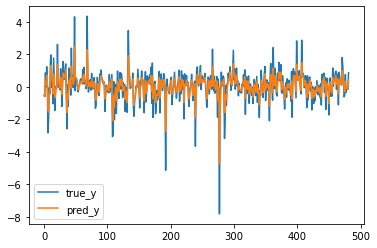

In [1136]:
true_y = y_test.values.ravel()
pred_y = best_model.predict(x_test.values)

from matplotlib import pyplot
pyplot.plot(true_y, label='true_y')
pyplot.plot(pred_y, label='pred_y')
pyplot.legend()
pyplot.show()

In [1137]:
df_ret = ivv_data.iloc[CopyX.index.values]['Adj Close'].pct_change(periods=1).fillna(0)

In [1138]:
df_ret1 = df_ret.reset_index(drop= True)[:x_train.shape[0],]
df_ret2 = df_ret.reset_index(drop= True)[x_train.shape[0]:,]

In [1139]:
positions = np.where(grid_search.predict(x_train.values)> 0,1,-1 ) 
dailyRet = pd.Series(positions).shift(1).fillna(0).values * df_ret1
dailyRet = dailyRet.fillna(0)
cumret = np.array(np.cumprod(dailyRet + 1) - 1)

rho, pval = spearmanr(y_test,grid_search.predict(x_test.values)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret[-1]) ** ((253/5) / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = ((253/5) ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6} Rho={:0.6} PVal={:0.6}\n'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


In-sample: CAGR=0.100976 Sharpe ratio=0.609369 maxDD=-0.275165 maxDDD=176 Calmar ratio=0.366964 Rho=0.9062 PVal=1.49033e-181



In [1140]:
positions2 = np.where(grid_search.predict(x_test.values)> 0,1,-1 )
dailyRet2 = pd.Series(positions2).shift(1).fillna(0).values * df_ret2
dailyRet2 = dailyRet2.fillna(0)
cumret2 = np.array(np.cumprod(dailyRet2 + 1) - 1)

rho, pval = spearmanr(y_test,grid_search.predict(x_test.values)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret2[-1]) ** ((253/5) / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = ((253/5) ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


Out-of-sample: CAGR=-0.0667799 Sharpe ratio=-0.380265 maxDD=-0.631329 maxDDD=320 Calmar ratio=-0.105777  Rho=0.9062 PVal=1.49033e-181



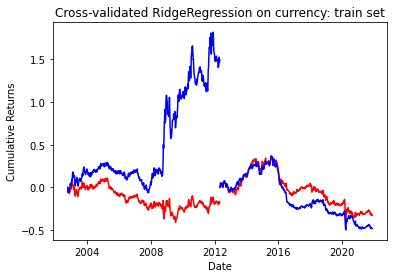

In [1141]:
positionsytrain = np.where(y_train.values.ravel() > 0,1,-1 )
dailyRetytrain = pd.Series(positionsytrain).shift(1).fillna(0).values * df_ret1
dailyRetytrain = dailyRetytrain.fillna(0)
cumretytrain = np.array(np.cumprod(dailyRetytrain + 1) - 1)



positionsytest = np.where(y_test.values.ravel() > 0,1,-1 )
dailyRetytest = pd.Series(positionsytest).shift(1).fillna(0).values * df_ret2
dailyRetytest = dailyRetytest.fillna(0)
cumretytest = np.array(np.cumprod(dailyRetytest + 1) - 1)



dates = df.iloc[CopyX.index.values]['Date']
dates= dates.reset_index(drop= True)[:x_train.shape[0],]
pyplot.figure(1)
pyplot.plot(dates, cumretytrain ,'r')
pyplot.plot(dates, cumret,'b')
pyplot.title('Cross-validated RidgeRegression on currency: train set')
pyplot.ylabel('Cumulative Returns')
pyplot.xlabel('Date')
dates = df.iloc[CopyX.index.values]['Date']
dates= dates.reset_index(drop= True)[x_train.shape[0]:,]
pyplot.plot(dates, cumretytest ,'r')
pyplot.plot(dates, cumret2,'b')



average return 0.001026
[-0.01164601  0.01851372]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.39480000000000004


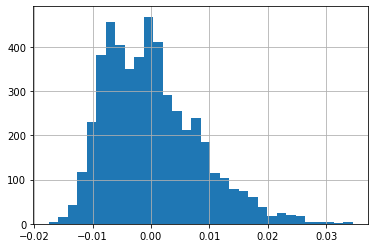

In [1142]:
import WhiteRealityCheckFor1
#white reality check

new_close=ivv_data.iloc[CopyX.index.values]['Adj Close'].reset_index(drop= True)[(x_train.shape[0]):,]
detrended_close = detrendPrice.detrendPrice(new_close)
detrended_ret1 = detrended_close.pct_change(periods=1).fillna(0)
detrended_syst_rets = detrended_ret1 * pd.Series(positions2).shift(1).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
pyplot.show()


In [1143]:
# Train error
train_result = mean_squared_error(grid_search.predict(x_train), y_train)
test_result = mean_squared_error(grid_search.predict(x_test), y_test)

#train_perc = "{:.0%}".format(train_result)
#test_perc = "{:.0%}".format(test_result)
#print(train_perc, test_perc)
print(train_result, test_result)


0.2578317876016487 0.23203255259354183
